In [138]:
%matplotlib inline

In [139]:
# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [1]:
import seqexplainer

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [148]:
import numpy as np
import matplotlib.pyplot as plt

# Data and model

In [5]:
import h5py

In [218]:
dataset = h5py.File("/cellar/users/aklie/projects/SeqExplainer/data/deAlmeida22/DeepSTARR_data.h5", 'r')

In [219]:
x_test = np.array(dataset['X_test']).astype(np.float32)
y_test = np.array(dataset['Y_test']).astype(np.float32)

In [220]:
dataset.close()

In [10]:
import os
import torch
import evoaug
from evoaug import evoaug, augment
from evoaug_analysis import utils, model_zoo

In [11]:

output_dir = "/cellar/users/aklie/projects/SeqExplainer/models/deAlmeida22/evoaug/attr_analysis"
ckpt_path = os.path.join(output_dir, 'DeepSTARR_baseline_1.ckpt')

deepstarr = model_zoo.DeepSTARR(2)
loss = torch.nn.MSELoss()
optimizer_dict = utils.configure_optimizer(deepstarr, lr=0.001, weight_decay=1e-6, decay_factor=0.1, patience=5, monitor='val_loss')
standard_cnn = evoaug.RobustModel(deepstarr, 
                                 criterion=loss, 
                                 optimizer=optimizer_dict, 
                                 augment_list=[])

# load model weights
standard_cnn = evoaug.load_model_from_checkpoint(standard_cnn, ckpt_path)
standard_cnn.eval()

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


RobustModel(
  (model): DeepSTARR(
    (activation): ReLU()
    (dropout4): Dropout(p=0.4, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm3): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm4): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc5): LazyLinear(in_features=0, out_features=256, bias=Tr

# Create null models

In [13]:
x_test.shape

(41186, 4, 249)

In [126]:
from seqexplainer._seq import dinuc_shuffle_seqs
def generate_profile_set(base_sequence, num_sample):
    """
    create a subset of sequences as background by matching nucleotide profiles
    :param base_sequence: sequences to use for matching
    :param num_sample: sample size
    :return: background set of onehot sequences
    """
    seq_model = np.mean(np.squeeze(base_sequence), axis=0)
    seq_model /= np.sum(seq_model, axis=0, keepdims=True)

    # sequence length
    L = seq_model.shape[1]

    x_null = np.zeros((num_sample, 4, L))
    for n in range(num_sample):

        # generate uniform random number for each nucleotide in sequence
        Z = np.random.uniform(0, 1, L)

        # calculate cumulative sum of the probabilities
        cum_prob = seq_model.cumsum(axis=0)

        # find bin that matches random number for each position
        for l in range(L):
            index = [j for j in range(4) if Z[l] < cum_prob[j, l]][0]
            x_null[n, index, l] = 1

    return x_null

def generate_shuffled_set(base_sequence, num_sample):
    """
    Funciton for creating a shuffled set of sequences based on an input set
    :param base_sequence: sequences to shuffle
    :param num_sample: sample size
    :return: background set of onehot sequences
    """
    # take a random subset of base_sequence
    shuffle = np.random.permutation(len(base_sequence))
    x_null = base_sequence[shuffle[:num_sample]]

    # shuffle nucleotides
    [np.random.shuffle(x) for x in x_null]
    return x_null

def generate_dinucleotide_shuffled_set(base_sequence, num_sample):
    """
    Function for dinuc shuffling provided sequences
    :param base_sequence: set of sequences
    :param num_sample: sample size
    :return: background set of onehot sequences
    """
    # take a random subset of base_sequence
    shuffle = np.random.permutation(len(base_sequence))
    x_null = base_sequence[shuffle[:num_sample]]

    # shuffle dinucleotides
    x_null = dinuc_shuffle_seqs(x_null)
    return x_null

def generate_subset_set(base_sequence, num_sample):
    """
    Function for creating a subset of sequences
    :param base_sequence: set of sequences
    :param num_sample: sample size
    :return: background set of onehot sequences
    """
    # take a random subset of base_sequence
    shuffle = np.random.permutation(len(base_sequence))
    x_null = base_sequence[shuffle[:num_sample]]
    return x_null


In [127]:
def nucleotide_content_seq(seq, ohe=True, normalize=True):
    if ohe:
        if normalize:
            return np.sum(seq, axis=1)/seq.shape[1]
        else:
            return np.sum(seq, axis=1)
    else:
        if normalize:
            return np.array([seq.count(nuc)/len(seq) for nuc in "ACGT"])
        else:
            return np.array([seq.count(nuc) for nuc in "ACGT"])
            
def nucleotide_content_seqs(seqs, axis=0, ohe=True, normalize=True):
    if ohe:
        if normalize:
            return np.sum(seqs, axis=axis)/seqs.shape[0]
        else:
            return np.sum(seqs, axis=axis)
    else:
        print("Not implemented yet")
                

In [128]:
def plot_nucleotide_freq(seqs, title="", figsize=(10, 5)):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.title(title)
    nuc_across_seq = nucleotide_content_seqs(seqs, axis=0, ohe=True, normalize=True)
    plt.plot(nuc_across_seq.T)
    plt.legend(["A", "C", "G", "T"])
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

In [146]:
from seqexplainer import generate_profile_set, generate_shuffled_set, generate_dinucleotide_shuffled_set, generate_subset_set
from seqexplainer._plot import plot_nucleotide_freq

In [147]:
null_profile = generate_profile_set(x_test, 1000)
null_shuffle = generate_shuffled_set(x_test, 1000)
null_dinuc_shuffle = generate_dinucleotide_shuffled_set(x_test, 1000)
null_subset = generate_subset_set(x_test, 1000)

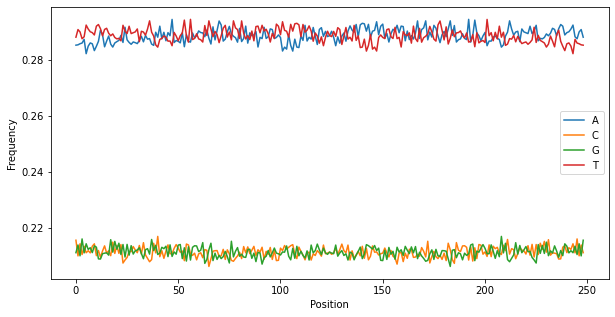

In [149]:
plot_nucleotide_freq(x_test)

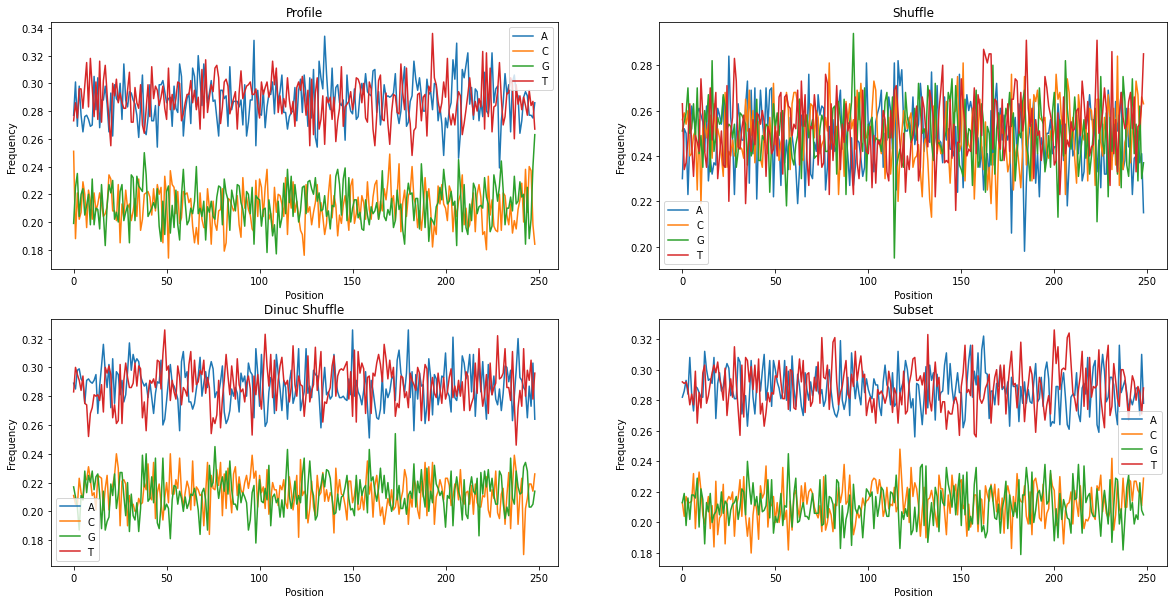

In [158]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
plot_nucleotide_freq(null_profile, title="Profile", ax=ax[0, 0])
plot_nucleotide_freq(null_shuffle, title="Shuffle", ax=ax[0, 1])
plot_nucleotide_freq(null_dinuc_shuffle, title="Dinuc Shuffle", ax=ax[1, 0])
plot_nucleotide_freq(null_subset, title="Subset", ax=ax[1, 1])
plt.show()

# Create perturb version of null model

## Embed a pattern

In [272]:
from seqexplainer._perturb import embed_pattern_seq, embed_pattern_seqs, embed_patterns_seq, embed_patterns_seqs, tile_pattern_seq
from seqexplainer._seq import reverse_complement_seq, ohe_seq, decode_seq, decode_seqs, _get_vocab

In [225]:
oheseq = x_test[0]
seq = decode_seq(oheseq, vocab="DNA")
print(seq) # original sequence
pattern = "AAAAAA" # first pattern, str
embedded_seq = embed_pattern_seq(oheseq, "AAGGGA", 0, ohe=True, pattern_encoding="str") # embed str pattern in ohe seq at position 0
print(decode_seq(embedded_seq, vocab="DNA")) 
pattern = "TTCCCT" # second pattern, str
ohe_pattern = ohe_seq(pattern, vocab="DNA") # convert to ohe
embedded_seq = embed_pattern_seq(embedded_seq, ohe_pattern, 8, ohe=True, pattern_encoding="ohe") # embed ohe pattern in ohe seq at position 8
print(decode_seq(embedded_seq, vocab="DNA"))
pattern = ohe_seq("GGGGGG", vocab="DNA") # third pattern, ohe
embedded_seq = decode_seq(embedded_seq, vocab="DNA") # convert to str   
embedded_seq = embed_pattern_seq(embedded_seq, pattern, 16, ohe=False, pattern_encoding="ohe") # embed ohe pattern in str seq at position 16
print(embedded_seq)
pattern = "TTTAAA" # fourth pattern, str
embedded_seq = embed_pattern_seq(embedded_seq, pattern, 24, ohe=False, pattern_encoding="str") # embed str pattern in str seq at position 24
print(embedded_seq)


AACATACCCTGCTCTAGCGTATTGCTTTTTAATTGGCAGAAAAATATGTGCTCCGGTCGGTCGGTATTAATATATGTATAAATCCAACCAATATGACACACATTTCATTCAATTTATGACGCACAGCTGACACACTTTTCCCACACTATCTCACCCACATGCATATACACACATACACAGGTTTTTCTGTGCGAAAAATGAATTACGATTCGTCGCGTTTTTTTTTTCTGGTCGCTTGTTTTCGTTTGG
AAGGGACCCTGCTCTAGCGTATTGCTTTTTAATTGGCAGAAAAATATGTGCTCCGGTCGGTCGGTATTAATATATGTATAAATCCAACCAATATGACACACATTTCATTCAATTTATGACGCACAGCTGACACACTTTTCCCACACTATCTCACCCACATGCATATACACACATACACAGGTTTTTCTGTGCGAAAAATGAATTACGATTCGTCGCGTTTTTTTTTTCTGGTCGCTTGTTTTCGTTTGG
AAGGGACCTTCCCTTAGCGTATTGCTTTTTAATTGGCAGAAAAATATGTGCTCCGGTCGGTCGGTATTAATATATGTATAAATCCAACCAATATGACACACATTTCATTCAATTTATGACGCACAGCTGACACACTTTTCCCACACTATCTCACCCACATGCATATACACACATACACAGGTTTTTCTGTGCGAAAAATGAATTACGATTCGTCGCGTTTTTTTTTTCTGGTCGCTTGTTTTCGTTTGG
AAGGGACCTTCCCTTAGGGGGGTGCTTTTTAATTGGCAGAAAAATATGTGCTCCGGTCGGTCGGTATTAATATATGTATAAATCCAACCAATATGACACACATTTCATTCAATTTATGACGCACAGCTGACACACTTTTCCCACACTATCTCACCCACATGCATATACACACATACACAGGTTTTTCTGTGCGAAAAATGAATTACGATTCGTCGCGTTTTTTTTTTCTGGTCGCTTGTTTTCGTTTGG


In [226]:
pattern = "AAAAAAAAA" # first pattern, str
tile_embedded_seqs = tile_pattern_seq(oheseq, pattern, starting_pos=0, step=1, ohe=True, pattern_encoding="str") # embed str pattern in ohe seq at every position

In [228]:
[print(seq) for seq in decode_seqs(tile_embedded_seqs[-5:-1])]

Decoding sequences:   0%|          | 0/4 [00:00<?, ?it/s]

AACATACCCTGCTCTAGCGTATTGCTTTTTAATTGGCAGAAAAATATGTGCTCCGGTCGGTCGGTATTAATATATGTATAAATCCAACCAATATGACACACATTTCATTCAATTTATGACGCACAGCTGACACACTTTTCCCACACTATCTCACCCACATGCATATACACACATACACAGGTTTTTCTGTGCGAAAAATGAATTACGATTCGTCGCGTTTTTTTTTTCTGGTCGCTAAAAAAAAATTGG
AACATACCCTGCTCTAGCGTATTGCTTTTTAATTGGCAGAAAAATATGTGCTCCGGTCGGTCGGTATTAATATATGTATAAATCCAACCAATATGACACACATTTCATTCAATTTATGACGCACAGCTGACACACTTTTCCCACACTATCTCACCCACATGCATATACACACATACACAGGTTTTTCTGTGCGAAAAATGAATTACGATTCGTCGCGTTTTTTTTTTCTGGTCGCTTAAAAAAAAATGG
AACATACCCTGCTCTAGCGTATTGCTTTTTAATTGGCAGAAAAATATGTGCTCCGGTCGGTCGGTATTAATATATGTATAAATCCAACCAATATGACACACATTTCATTCAATTTATGACGCACAGCTGACACACTTTTCCCACACTATCTCACCCACATGCATATACACACATACACAGGTTTTTCTGTGCGAAAAATGAATTACGATTCGTCGCGTTTTTTTTTTCTGGTCGCTTGAAAAAAAAAGG
AACATACCCTGCTCTAGCGTATTGCTTTTTAATTGGCAGAAAAATATGTGCTCCGGTCGGTCGGTATTAATATATGTATAAATCCAACCAATATGACACACATTTCATTCAATTTATGACGCACAGCTGACACACTTTTCCCACACTATCTCACCCACATGCATATACACACATACACAGGTTTTTCTGTGCGAAAAATGAATTACGATTCGTCGCGTTTTTTTTTTCTGGTCGCTTGTAAAAAAAAAG


[None, None, None, None]

## Remove a pattern

In [257]:
from seqexplainer._seq import reverse_complement_seqs, decode_seq
def find_patterns_seq(seq, patterns, pattern_names=None, starting_pos=0, check_rev_comp=True):
    """Function to find patterns and annotate the position and orientation of patterns in sequences
    
    Users should be able to specify an exact pattern or pass in pattern to search for.
    Can make use of the JASPAR database to find patterns. 
    """
    if isinstance(seq, np.ndarray):
        seq = decode_seq(seq, vocab="DNA") 

    if isinstance(patterns, dict):
        pattern_names = list(patterns.keys())
        patterns = list(patterns.values())

    if isinstance(patterns, str):
        patterns = [patterns]
    
    if check_rev_comp:
        rev_patterns = list(reverse_complement_seqs(patterns, verbose=False))
        all_patterns = patterns + rev_patterns
        orientations = ["F"] * len(patterns) + ["R"] * len(rev_patterns)
        if pattern_names is not None:
            all_pattern_names = pattern_names + pattern_names
        else:
            all_pattern_names = [f"pattern{i}" for i in range(len(patterns))] + [f"pattern{i}" for i in range(len(patterns))]
    
    else:
        all_patterns =patterns 
        orientations = ["F"] * len(patterns)
        if pattern_names is not None:
            all_pattern_names = pattern_names
        else:
            all_pattern_names = [f"pattern{i}" for i in range(len(patterns))]
    
    longest_pattern = max(patterns, key=len)
    shortest_pattern = min(patterns, key=len)
    pattern_name_dict = dict(zip(all_patterns, all_pattern_names))
    pattern_orient_dict = dict(zip(all_patterns, orientations))
    pattern_hits_dict = {}
    for i in range(starting_pos, len(seq)-len(shortest_pattern)+1):
        for j in range(len(longest_pattern), len(shortest_pattern)-1, -1):
            pattern = seq[i:i+j]
            if pattern in all_patterns:
                pattern_hits_dict.setdefault(i, []).append(pattern_name_dict[pattern])
                pattern_hits_dict.setdefault(i, []).append(pattern_orient_dict[pattern])

    return pattern_hits_dict

def find_patterns_seqs(seqs, patterns, pattern_names=None, starting_pos=0, check_rev_comp=True):
    """Function to find patterns and annotate the position and orientation of patterns in sequences
    
    Users should be able to specify an exact pattern or pass in pattern to search for.
    Can make use of the JASPAR database to find patterns. 
    """
    if isinstance(seqs, np.ndarray):
        seqs = decode_seqs(seqs, vocab="DNA") 

    all_hits = []
    for seq in seqs:
        hits = find_patterns_seq(seq, patterns, pattern_names=pattern_names, starting_pos=starting_pos, check_rev_comp=check_rev_comp)
        all_hits.append(hits)
    return all_hits

In [276]:
def occlude_patterns_seq(
    seq,
    patterns,
    starting_pos=0,
    check_rev_comp=True,
    max_occluded=None
):
    # find motifs in seq
    hits = find_patterns_seq(seq, pattern, starting_pos=starting_pos, check_rev_comp=check_rev_comp)

    if max_occluded is None:
        max_occluded = len(hits)
    
    # occlude motifs in seq
    for pos, motif in hits.items():
        
        # Get random pattern of same size as pattern
        random_pattern = ohe_seq("".join(np.random.choice(["A", "C", "G", "T"], size=len(pattern))))
        seq = embed_pattern_seq(seq, random_pattern, pos, ohe=True, pattern_encoding="ohe")
    return seq

def occlude_patterns_seqs(
    seqs,
    patterns,
    starting_pos=0,
    check_rev_comp=True,
    max_occluded=None
):
    # find motifs in seq
    hits = find_patterns_seqs(seqs, pattern, starting_pos=starting_pos, check_rev_comp=check_rev_comp)

    if max_occluded is None:
        max_occluded = len(hits)
    
    # occlude motifs in seq
    for i, hit in enumerate(hits):
        for pos, motif in hit.items():
            # Get random pattern of same size as pattern
            random_pattern = ohe_seq("".join(np.random.choice(["A", "C", "G", "T"], size=len(pattern))))
            seqs[i] = embed_pattern_seq(seqs[i], random_pattern, pos, ohe=True, pattern_encoding="ohe")
    return seqs

In [284]:
motif_hits = find_patterns_seq(
    x_test[0], 
    patterns={"motif2": "TTCT"}, 
    pattern_names=None, 
    starting_pos=0, 
    check_rev_comp=True
)
motif_hits

{37: ['motif2', 'R'], 184: ['motif2', 'F'], 225: ['motif2', 'F']}

In [279]:
print(reverse_complement_seq(decode_seq(x_test[0])[37:41]))
print(decode_seq(x_test[0])[184:188])
print(decode_seq(x_test[0])[225:229])

TTCT
TTCT
TTCT


In [280]:
occluded_seq = occlude_patterns_seq(
    x_test[0],
    pattern="TTCT",
)

In [281]:
print(reverse_complement_seq(decode_seq(occluded_seq)[37:41]))
print(decode_seq(occluded_seq)[184:188])
print(decode_seq(occluded_seq)[225:229])

CATT
ACTG
AGCA


In [283]:
motif_hits = find_patterns_seq(
    occluded_seq, 
    patterns={"motif2": "TTCT"}, 
    pattern_names=None, 
    starting_pos=0, 
    check_rev_comp=True
)
motif_hits

{}

# Get differences in predictions

In [2]:
def gc_bias(self, 
    motif='UGCAUG', 
    motif_position=17,
    gc_motif='GCGCGC', 
    gc_positions=[34, 2], 
    class_index=0
):
    """GIA to find GC-bias"""

    all_scores = []


    # background sequence with gc-bias on right side
    all_scores.append(self.embed_predict_effect((gc_motif, gc_positions[0]), class_index))

    # background sequence with motif at center
    all_scores.append(self.embed_predict_effect((motif, motif_position), class_index))

    # create interventions for gc bias
    for position in gc_positions:

        interventions = [(motif, motif_position), (gc_motif, position)]
        all_scores.append(self.embed_predict_effect(interventions, class_index))

    return np.array(all_scores)